# Vehicle Detection and Tracking

## Udacity Self Driving Car Engineer Nanodegree - Project 5

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [27]:
import cv2
import glob
import time

import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio 
imageio.plugins.ffmpeg.download()

from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler


from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from moviepy.editor import VideoFileClip

%matplotlib inline

In [28]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1. Drawing Rectangles on images

Defining a function "do_draw_boxes()" to draw bounding rectangles on identified vehicles in images.

In [29]:
def do_draw_boxes(img, bounding_boxes, color=(0, 0, 255), thick=7):
    # Make image copy
    copy_img = np.copy(img)
    # Draw bounding box on the passed-in image 
    for bounding_boxes in bounding_boxes:
        cv2.rectangle(copy_img, bounding_boxes[0], bounding_boxes[1], color, thick)
    return copy_img

In [30]:
import os

# o/p folder creation for images (output_images)
out_images_folder = 'output_images'
if not os.path.exists(out_images_folder):
    os.makedirs(out_images_folder)
    
    
# o/p folder creation for video (output_video)
out_video_folder = 'output_video'
if not os.path.exists(out_video_folder):
    os.makedirs(out_video_folder)    
    
    
# o/p folder for image snippets from video 
image_snippets_for_out_video_folder = 'image_snippets_for_video'
if not os.path.exists(out_video_folder+"/"+image_snippets_for_out_video_folder):
    os.makedirs(out_video_folder+"/"+image_snippets_for_out_video_folder)     

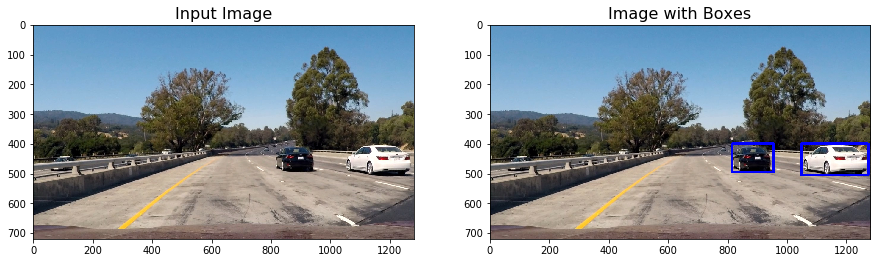

In [31]:
import PIL
from PIL import Image

out_images_folder = 'output_images'
out_video_folder = 'output_video'

sample_test_image = 'test_images/test1.jpg'
bounding_boxes = [((812,400),(952,495)),((1045,400),(1270,505))]

f, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))

axis1.set_title("Input Image", fontsize=16)
axis1.imshow(cv2.cvtColor(cv2.imread(sample_test_image), cv2.COLOR_BGR2RGB))

image_with_boxes = do_draw_boxes(mpimg.imread(sample_test_image),bounding_boxes=bounding_boxes)
image_with_boxes = PIL.Image.fromarray(image_with_boxes)

axis2.set_title("Image with Boxes", fontsize=16)
axis2.imshow(image_with_boxes)

plt.savefig(out_images_folder+"/1.image_with_boxes_out.png")

# 2. Histogram of Oriented Gradients
Function retrive_hog_features() to compute a Histogram of Oriented Gradients for a given image.

In [32]:
def retrive_hog_features(img, color_space='YUV'):
    # Call with two outputs if vis==True
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)

    return np.ravel(hog.compute(feature_image))

In [33]:
hog_descriptor = cv2.HOGDescriptor((64,64), (8,8), (8,8), (8,8), 9)
image = imread(sample_test_image)
print ("HOG shape : ",hog_descriptor.compute(image).shape)

HOG shape :  (7314624, 1)


## 3. Extract HOG features to build datasets of Car and Non-car images (to train a classifier)

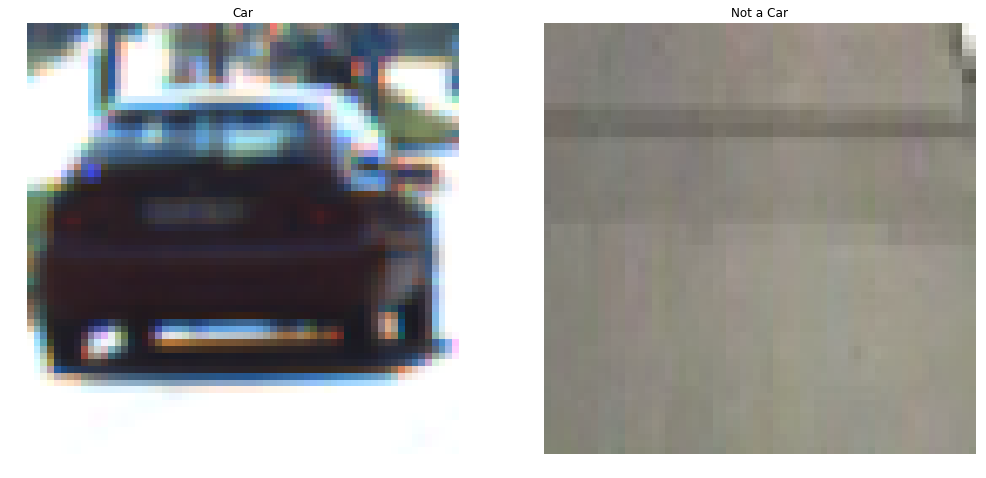

In [34]:
# Read car and non-car image sets
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

car_ind = np.random.randint(0, len(cars))
not_car_ind = np.random.randint(0, len(notcars))

f, (ax1,ax2) = plt.subplots(1,2, figsize=(17,11))
ax1.axis('off')
ax1.set_title('Car')
ax1.imshow(mpimg.imread(cars[car_ind]))
ax2.axis('off')
ax2.set_title('Not a Car')
ax2.imshow(mpimg.imread(notcars[not_car_ind]))
plt.savefig(out_images_folder+'/2.car_and_not_a_car_Out.png')

In [35]:
EXPECTED_SIZE = 64

from skimage.feature import hog

# Hog Feature & Visualization
def extract_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    # Call with two outputs if vis==True
    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=True, feature_vector=feature_vec)
    return features, hog_image
    

    
def extract_image_features(images, color_space='RGB', size = (EXPECTED_SIZE, EXPECTED_SIZE)):
    features_list = [] # feature vectors appended to it.
    image_list = []
    # Traverse the list of images
    hog_descriptor = cv2.HOGDescriptor((EXPECTED_SIZE,EXPECTED_SIZE), (16,16), (8,8), (8,8), 9)
    
    i = 0
    for image in images:
        image = imread(image)
        if size != (EXPECTED_SIZE, EXPECTED_SIZE):
            img = cv2.resize(image, size)
            
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'Lab':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 

        hog_features = np.ravel(hog_descriptor.compute(feature_image))
        features_list.append(hog_features)
                        
    return features_list # Returns list

In [36]:
# Datasets Building 
car_features = extract_image_features(cars, color_space='YUV')
notcar_features = extract_image_features(notcars, color_space='YUV')

In [37]:
# Print the number of features for each image
print("Number of features : ",car_features[10].shape)

Number of features :  (1764,)


([], <a list of 0 Text yticklabel objects>)

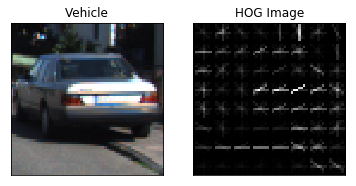

In [38]:
vehicle = plt.imread('vehicles/KITTI_extracted/2002.png')
plt.subplot(1,2,1)
plt.imshow(vehicle)
plt.title('Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
features, hog = extract_hog_features(vehicle[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, feature_vec=True)
plt.imshow(hog, cmap='gray')
plt.title('HOG Image')
plt.savefig(out_images_folder+'/3.car_and_hog_Out.png')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

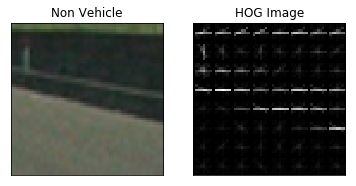

In [39]:
from skimage.feature import hog

non_vehicle = plt.imread('non-vehicles/GTI/image3319.png')
plt.subplot(1,2,1)
plt.imshow(non_vehicle)
plt.title('Non Vehicle')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
features, hog = extract_hog_features(non_vehicle[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, feature_vec=True)
plt.imshow(hog, cmap='gray')
plt.title('HOG Image')
plt.savefig(out_images_folder+'/4.non_car_and_hog_Out.png')
plt.xticks([])
plt.yticks([])

## Scale the features to have 0 mean and unit variance, before training the classifier.

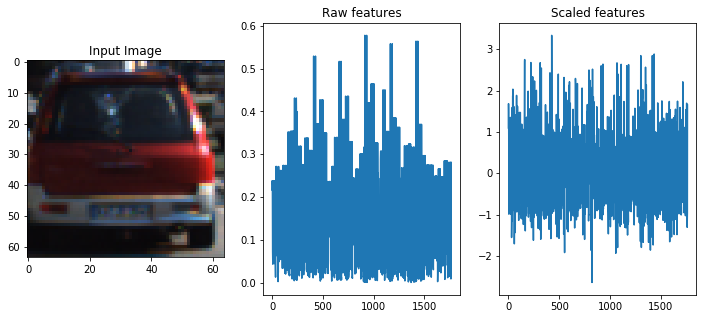

In [40]:
# Working on car dataset

if len(car_features) <= 0:
    print('Got empty feature vectors...')
else:    
    # Generate an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    x_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_x = x_scaler.transform(X)
    picked_random_car = np.random.randint(0, len(cars))
    
    # Display an example of raw and scaled features
    figure = plt.figure(figsize=(12,5))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[picked_random_car]))
    plt.title('Input Image')
    plt.subplot(132)
    plt.plot(X[picked_random_car])
    plt.title('Raw features')
    plt.subplot(133)
    plt.plot(scaled_x[picked_random_car])
    plt.title('Scaled features')
    plt.savefig(out_images_folder+"/5.random_car_and_features_plot.png")
    

In [41]:
# Create Labels Array
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Divide data into randomized training and test sets
rand_state = 4444
X_train, X_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=rand_state)

# 4. Training classifiers

   - ## 4A. Training a Linear SVM.

In [42]:
svc = LinearSVC()

# Check the training time for the SVC
time1=time.time()
svc.fit(X_train, y_train)
time2 = time.time()

print ("\n\nTraining Classifier : SVC")
print ("-------------------------------------------------\n")
print('Training time (in secs) : ',time2-time1)

# Training Scores of SVC
print('Training Accuracy : ', svc.score(X_train, y_train))
print('Test Accuracy : ', svc.score(X_test, y_test))
      
# Prediction time
time1=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
time2 = time.time()
print('Time to predict (in secs) : ',time2-time1)
print ("-------------------------------------------------")



Training Classifier : SVC
-------------------------------------------------

Training time (in secs) :  6.9591569900512695
Training Accuracy :  1.0
Test Accuracy :  0.954391891892
Time to predict (in secs) :  0.0003161430358886719
-------------------------------------------------


- ## 4B. Training a Logistic Regression Classifier

In [43]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(max_iter=10)
time1=time.time()
lrc.fit(X_train, y_train)
time2 = time.time()

print ("\n\nTraining Classifier : Logistic Regression Classifier")
print ("------------------------------------------------------\n")
print('Training time (in secs) : ',time2-time1)
print('Training Accuracy : ', lrc.score(X_train, y_train))
print('Test Accuracy : ', lrc.score(X_test, y_test))

# Prediction time
time1=time.time()
prediction = lrc.predict(X_test[0].reshape(1, -1))
time2 = time.time()
print('Time to predict (in secs) : ',time2-time1)
print ("------------------------------------------------------")



Training Classifier : Logistic Regression Classifier
------------------------------------------------------

Training time (in secs) :  7.389700889587402
Training Accuracy :  0.99732545045
Test Accuracy :  0.958896396396
Time to predict (in secs) :  0.0002739429473876953
------------------------------------------------------


- ## 4C. Training a Multi-Layer Perceptron classifier

In [44]:
from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(random_state=999)
time1=time.time()
mlp.fit(X_train, y_train)
time2 = time.time()

print ("\n\nTraining Classifier : Multi-Layer Perceptron classifier")
print ("------------------------------------------------------\n")
print('Training time (in secs) : ',time2-time1)
print('Training Accuracy : ', mlp.score(X_train, y_train))
print('Test Accuracy : ', mlp.score(X_test, y_test))

# Prediction time
time1=time.time()
prediction = mlp.predict(X_test[0].reshape(1, -1))
time2 = time.time()
print('Time to predict (in secs) : ',time2-time1)
print ("-------------------------------------------------------")

print ("\n\n\n\n")
# Display confusion matrix of the predictions from the MLP
predicted = mlp.predict(X_test)
conf_mat = pd.DataFrame(confusion_matrix(predicted, y_test))

conf_mat



Training Classifier : Multi-Layer Perceptron classifier
------------------------------------------------------

Training time (in secs) :  12.164462089538574
Training Accuracy :  1.0
Test Accuracy :  0.991835585586
Time to predict (in secs) :  0.0007510185241699219
-------------------------------------------------------







,0,1
0,1790,22
1,7,1733


## MLP classifier has much higher accuracy, even though its slow

## Saving the models.

In [45]:
# Save MLP and Scaler
joblib.dump(mlp, 'mlp.pk')
joblib.dump(x_scaler, 'scaler.pk')

['scaler.pk']

## Reading the models.

In [46]:
# Load MLP and Scaler
mlp = joblib.load('mlp.pk')
X_scaler = joblib.load('scaler.pk')

## Defining sliding_window() fn.

In [47]:
def sliding_window(img, x_start_stop=[None, None], 
                   y_start_stop=[None, None], 
                   xy_window=(64, 64), 
                   xy_overlap=(0.75, 0.75)):
    # Verify and fix start and stops.
    # If x, y start/stop positions are not defined, fix it to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute search region span.
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    x_no_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    y_no_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    x_no_windows = np.int(x_span/x_no_pix_per_step) 
    y_no_windows = np.int(y_span/y_no_pix_per_step)
    
    # Initialize a list for appending window positions
    windows_list = []
    
    # Loop through finding x and y window positions
    # One can vectorize this step, but in practice you'll be considering 
    # windows one by one with your classifier, so looping makes sense
    for y_win in range(y_no_windows):
        for x_win in range(x_no_windows):
            # Determine window position
            start_x = x_win*x_no_pix_per_step + x_start_stop[0]
            end_x = (x_win+1)*x_no_pix_per_step + x_start_stop[0]
            start_y = y_win*y_no_pix_per_step + y_start_stop[0]
            end_y = (y_win+1)*y_no_pix_per_step + y_start_stop[0]
            
            # Add window position to list
            windows_list.append(((start_x, start_y), (end_x, end_y)))
    # Return the list of windows
    return windows_list

In [48]:
def annotate_image(image):
    # fetch Image name
    image_name = image.split('/', 1 )[1]
    image_name = image_name.split('.', 1 )[0]
    
    image = imread(image)
    detected_windows = []
    total_count = 0
    size = 320
    MAX_SIZE = 720
    OVERLAP_VALUE = 0.8
    
    while size < MAX_SIZE:
        windows = sliding_window(image, x_start_stop=[None, None], 
                                 y_start_stop=[400, 660], xy_window=(size, size), 
                                 xy_overlap=(OVERLAP_VALUE, OVERLAP_VALUE))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = retrive_hog_features(current,color_space='YUV')
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if mlp.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected_windows.append(window)
            total_count += 1
        size += 16
        
    result = np.copy(image)
    mask = np.zeros_like(image)
    
    # Place all boxes on the mask image
    mask = do_draw_boxes(mask, bounding_boxes=detected_windows, thick=-1)
    
    # Determine contours in mask
    image2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Get the coordinates of a bounding rect for each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Draw the bounding rectangles on the result image
        cv2.rectangle(result, (x, y), (x + w, y + h), (0,255,0), 6)
        M = cv2.moments(contour)
        c = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
        cv2.circle(result, c, 15, (255, 0, 0), -1)
        
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(17,11))
    ax1.axis('off')
    ax1.set_title('Input Image')
    ax1.imshow(image)
    ax2.axis('off')
    ax2.set_title('Detected Car Positions')
    ax2.imshow(mask, cmap='hot')
    ax3.axis('off')
    ax3.set_title('Image Annotated')
    ax3.imshow(result)
    plt.savefig(out_images_folder+"/"+image_name+'_out.png')

## 5. Annotate images from 'test_images' folder 

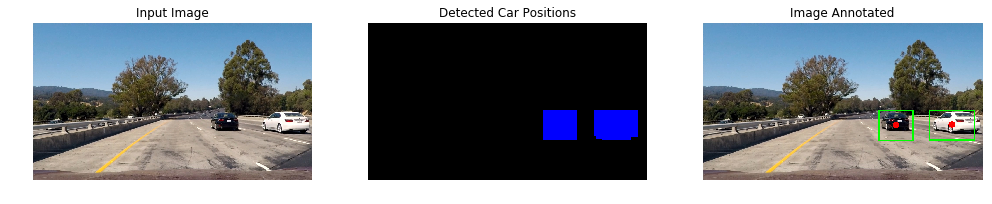

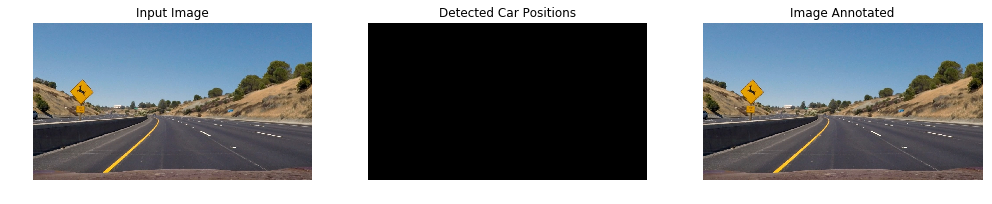

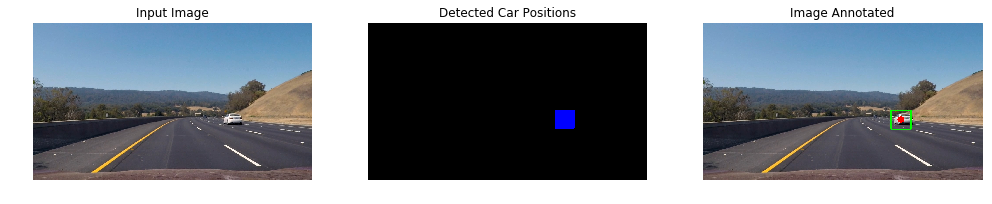

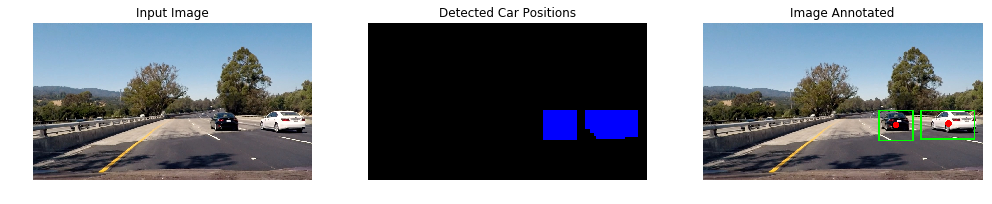

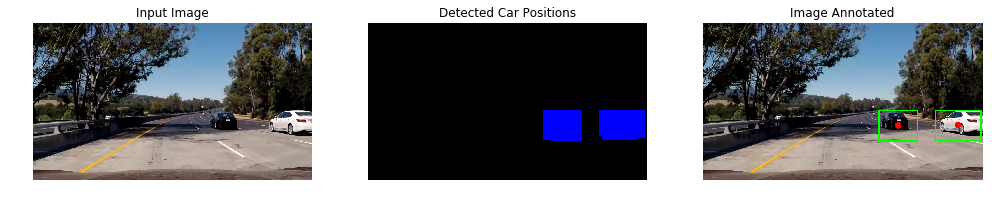

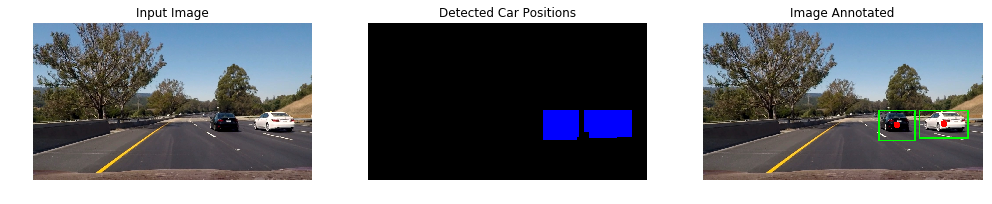

In [49]:
test_images = 'test_images/test*.jpg'
test_images_list = glob.glob(test_images)

for image in test_images_list:
    annotate_image(image);   

## 6. Detect vehicles in Video (project_video.mp4)

In [50]:
from collections import deque
class boxes:
    def __init__(self):
        self.cnt = 0
        self.detections = deque(maxlen=12)

def process_vid(image):
    detected_windows = [] 
    size = 320
    count = 0
    MAX_SIZE = 720
    OVERLAP_VALUE = 0.8
    
    while size < MAX_SIZE:
        windows = sliding_window(image, x_start_stop=[640, None], y_start_stop=[400, 660], 
                            xy_window=(size, size), xy_overlap=(OVERLAP_VALUE, OVERLAP_VALUE))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = retrive_hog_features(current, color_space='YUV')
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if mlp.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected_windows.append(window)
            count += 1
        size += 16
        
    result = np.copy(image).astype('uint8')
    
    mask = np.zeros_like(image)
    mask = do_draw_boxes(mask, bounding_boxes=detected_windows, thick=-1)
    rect_list = []
    image2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        rect_list.append([x,y,x+w,y+h])
        
    Boxes.detections.append(rect_list)
    all_boxes = []
    combined = np.ravel(np.array(Boxes.detections))
    
    for i in range(len(combined)):
        all_boxes.extend(np.ravel(combined[i]))
    new_boxes = []
    i = 0
    
    while i <= len(all_boxes)-3:
        new_boxes.append(all_boxes[i:i+4])
        i += 4
        
    rects,w = cv2.groupRectangles(np.array(new_boxes).tolist(), 10,.1)
    
    for rect in rects:
        cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (0,255,0), 5)
    Boxes.cnt += 1
    
    '''
    #################################################################
    # Dummy code to capture 50 random frames
    snip_no=np.random.randint(0, 30)
    rand_val = np.random.randint(0, 3)
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(17,11))
    ax1.axis('off')
    ax1.set_title("Video's Input Image")
    ax1.imshow(image)
    ax2.axis('off')
    ax2.set_title('Detected Car Position(s)')
    ax2.imshow(mask, cmap='hot')
    ax3.axis('off')
    ax3.set_title("Annotated Video's Input Image")
    ax3.imshow(result)
    if rand_val %2 == 0 :
        plt.savefig(out_video_folder+"/"+image_snippets_for_out_video_folder+"/testt"+str(snip_no)+".png")         
    #################################################################
    '''
    
    return result

In [51]:
Boxes = boxes()
output = out_video_folder+'/project_video_ouput.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(process_vid)
print ("Printing 30 video frames snippets with hog features detected ...... \n\n")
%time clip.write_videofile(output, audio=False)

Printing 30 video frames snippets with hog features detected ...... 


[MoviePy] >>>> Building video output_video/project_video_ouput.mp4
[MoviePy] Writing video output_video/project_video_ouput.mp4


100%|█████████▉| 1260/1261 [05:35<00:00,  4.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_ouput.mp4 

CPU times: user 8min 1s, sys: 1min 28s, total: 9min 29s
Wall time: 5min 37s


In [52]:
from IPython.display import HTML

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('output_video_folder/project_video_ouput.mp4'))